## Spam Classification

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.svm import OneClassSVM

In [2]:
#Returns the number of missing values for each feature
def nan_values(data, axis = 0):
    nans = []
    if axis == 0:
        for column in data.columns:
            nans += [data[column].shape[0] - data[column].dropna().shape[0]]
        nans = pd.Series(nans, index = data.columns)
        return nans
    elif axis == 1:
        for row in data.index:
            nans += [data.loc[row,:].shape[0] - data.loc[row,:].dropna().shape[0]]
        nans = pd.Series(nans, index = data.index)
        return nans
#Visualizes the roc-curve
def plotAUC(truth, pred, lab='model'):
    sns.set('talk', 'whitegrid', 'dark', font_scale=1, rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
    if (type(truth) is not list) & (type(pred) is not list):
        fpr, tpr, _ = roc_curve(truth, pred)
        roc_auc = auc(fpr, tpr)
        lw = 2
        c = (np.random.rand(), np.random.rand(), np.random.rand())
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color=c, lw=lw, label=lab + '(AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.legend(loc="lower right")
    elif (type(truth) is list) & (type(pred) is list) & (len(pred) == len(truth)):
        shape = len(truth)
        plt.figure(figsize=(6, 4 * int(np.ceil(shape / 2))))
        for t, p, l in zip(truth, pred, lab):
            fpr, tpr, _ = roc_curve(t, p)
            roc_auc = auc(fpr, tpr)
            lw = 2
            c = (np.random.rand(), np.random.rand(), np.random.rand())
            plt.plot(fpr, tpr, color=c, lw=lw, label=l+'(AUC = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlim([-0.05, 1.05])
            plt.ylim([-0.05, 1.05])
            plt.legend(loc="lower right")
#Misclassification error rate
def misclass_error(true, pred):
    return 1 - accuracy_score(true, pred)

#### Processing the data

In [3]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data'
col_names_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names'

In [4]:
data = pd.read_csv(data_url, header = None)
col_names = pd.read_csv(col_names_url,header = None, skiprows = 32)[0]
data.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [5]:
col_names = col_names.apply(lambda x:x[:x.find(':')]).values
col_names = np.append(col_names,'target')
data.columns = col_names
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,target
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [6]:
nan_values(data)

word_freq_make                0
word_freq_address             0
word_freq_all                 0
word_freq_3d                  0
word_freq_our                 0
word_freq_over                0
word_freq_remove              0
word_freq_internet            0
word_freq_order               0
word_freq_mail                0
word_freq_receive             0
word_freq_will                0
word_freq_people              0
word_freq_report              0
word_freq_addresses           0
word_freq_free                0
word_freq_business            0
word_freq_email               0
word_freq_you                 0
word_freq_credit              0
word_freq_your                0
word_freq_font                0
word_freq_000                 0
word_freq_money               0
word_freq_hp                  0
word_freq_hpl                 0
word_freq_george              0
word_freq_650                 0
word_freq_lab                 0
word_freq_labs                0
word_freq_telnet              0
word_fre

In [7]:
X = data.drop('target', axis = 1)
y = data['target']
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

### CART and Random Forest

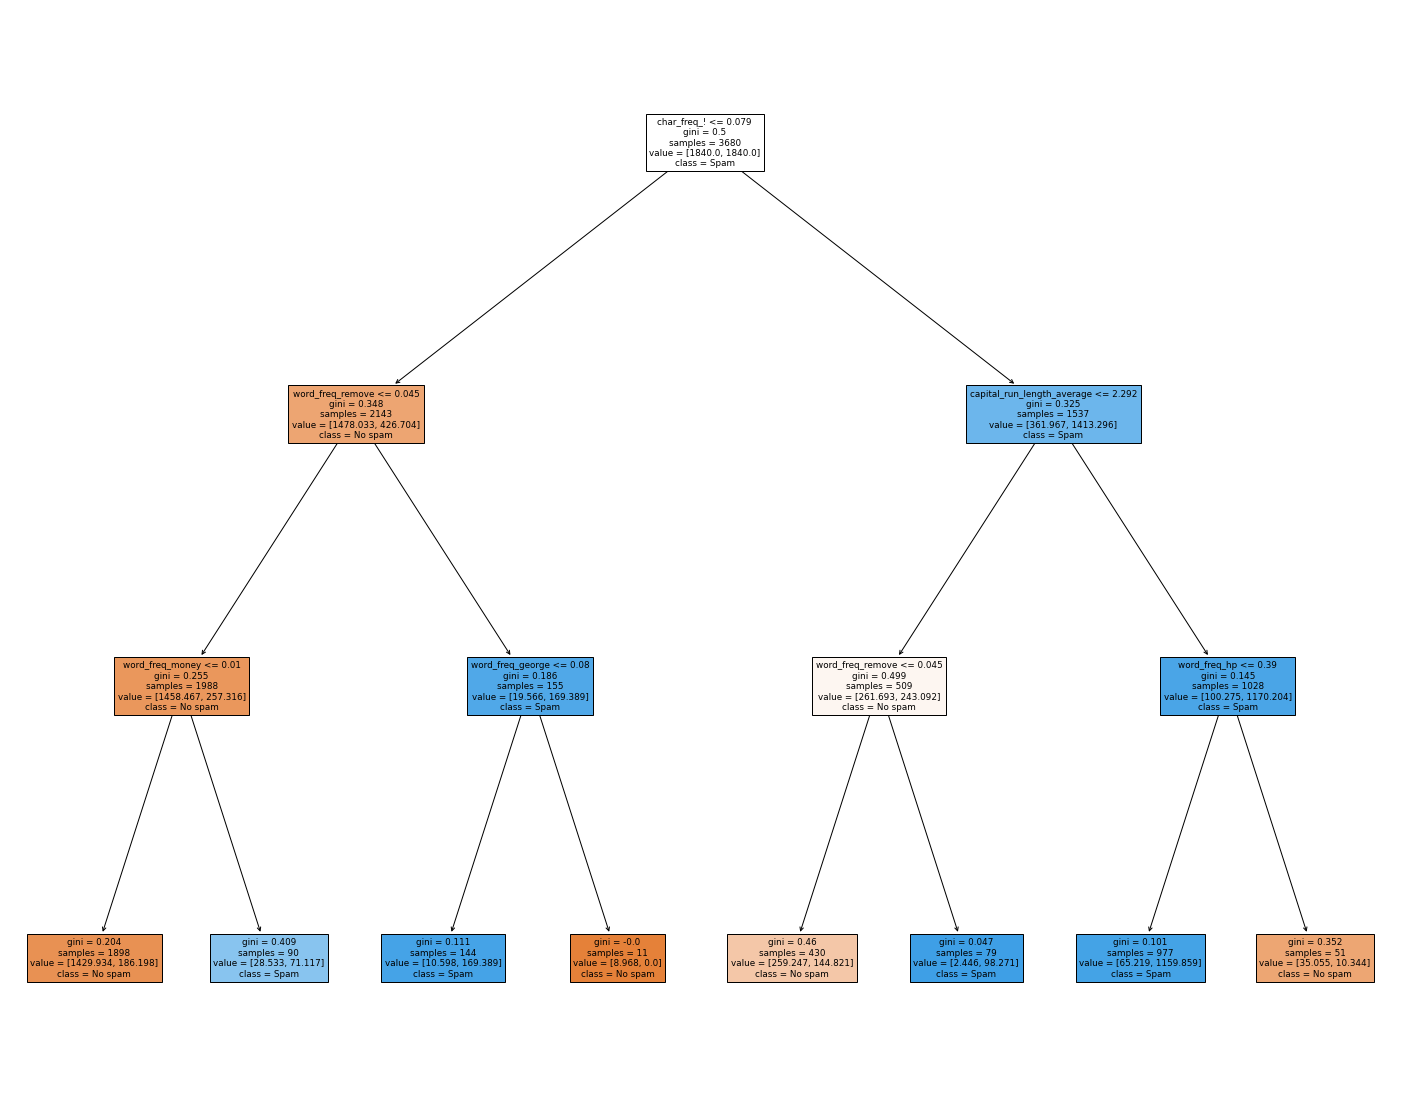

In [8]:
#Max depth here is set to 3 only in order to presume the informativeness of the visualization
model = DecisionTreeClassifier(random_state = 42, class_weight = 'balanced', max_depth = 3)
model.fit(x_train, y_train)
fig = plt.figure(figsize = (25,20))
_ = tree.plot_tree(model, 
                   feature_names = x_train.columns.values.tolist(),  
                   class_names = ['No spam','Spam'],
                   filled = True)

In [9]:
cart_model = DecisionTreeClassifier(random_state = 42,max_depth = 6,
                                    min_samples_split = 10, class_weight = 'balanced')
rf_model = RandomForestClassifier(random_state = 42,max_depth = 6,
                                  min_samples_split = 10, class_weight = 'balanced')
cart_model.fit(x_train,y_train)
rf_model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=10, random_state=42)

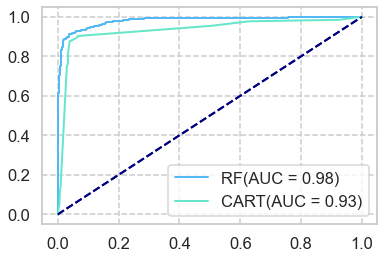

In [10]:
plotAUC([y_test,y_test], [rf_model.predict_proba(x_test)[:,1],
                cart_model.predict_proba(x_test)[:,1]],['RF','CART'])

It's obvious, that Random Forest is performing better than the CART model. On the chart above we can clearly see, that for any value of FPR(False Positive Rate) the TPR(True positive Rate) of Random Forest is always higher,so here one may even dare to say that one model is definitely better than another.

In [11]:
acc = []
acc += [accuracy_score(y_test, rf_model.predict(x_test))]
acc += [accuracy_score(y_test, cart_model.predict(x_test))]
rec = []
rec += [recall_score(y_test, rf_model.predict(x_test))]
rec += [recall_score(y_test, cart_model.predict(x_test))]
prec = []
prec += [precision_score(y_test, rf_model.predict(x_test))]
prec += [precision_score(y_test, cart_model.predict(x_test))]
f1= []
f1 += [f1_score(y_test, rf_model.predict(x_test))]
f1 += [f1_score(y_test, cart_model.predict(x_test))]
auc = []
auc += [roc_auc_score(y_test, rf_model.predict_proba(x_test)[:,1])]
auc += [roc_auc_score(y_test, cart_model.predict_proba(x_test)[:,1])]
performance = pd.DataFrame([])
performance['Accuracy'] = acc
performance['Recall'] = rec
performance['Precision'] = prec
performance['f1_score'] = f1
performance['AUC'] = auc
performance.index = ['Random Forest','CART']
performance

,Accuracy,Recall,Precision,f1_score,AUC
Random Forest,0.939197,0.905128,0.948925,0.926509,0.980236
CART,0.923996,0.876923,0.939560,0.907162,0.932768


Other metrics only confirm the above statement

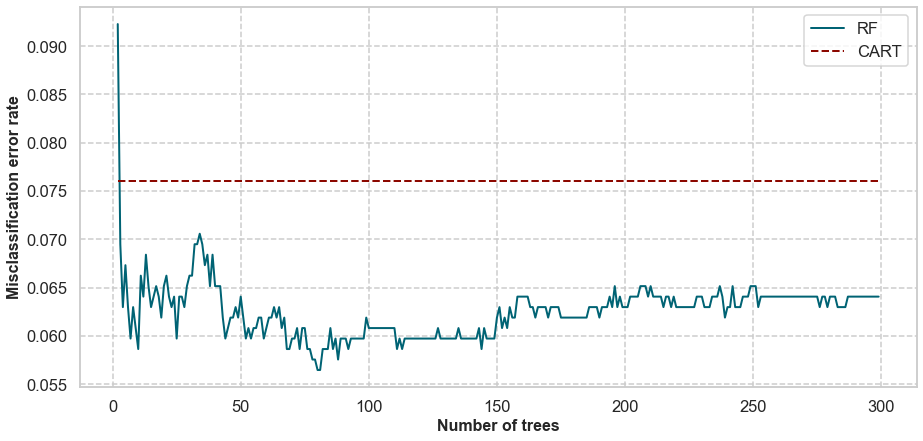

In [12]:
number_of_trees = np.arange(2,300)
size = len(number_of_trees)
non_iterable_params = {'random_state':42,'max_depth':6,
                       'min_samples_split':10,'class_weight':'balanced'}
models = [RandomForestClassifier().set_params(**non_iterable_params).set_params(**{'n_estimators' : i}).fit(x_train,y_train) for i in number_of_trees]
errors = [misclass_error(y_test,model.predict(x_test)) for model in models]
plt.figure(figsize = (15,7))
plt.plot(number_of_trees, errors, lw = 2,c = 'c', label = 'RF')
plt.plot(number_of_trees, np.repeat(misclass_error(y_test, cart_model.predict(x_test)),size), 
                                    lw = 2,ls = '--',c = 'r', label = 'CART')
plt.xlabel('Number of trees', fontsize = 16, fontweight = 'bold')
plt.ylabel('Misclassification error rate', fontsize = 16, fontweight = 'bold')
plt.legend()

### SVM

In [19]:
x_train_non_spam = x_train[y_train == 0]
y_test[y_test == 0] = -1

In [33]:
svm_model = OneClassSVM(gamma = 1e-9)
svm_model.fit(x_train_non_spam)

OneClassSVM(gamma=1e-09)

In [34]:
print('Misclassification error: ' + str(misclass_error(y_test, svm_model.predict(x_test))))

Misclassification error: 0.4581976112920738
